In [1]:
%run DensityPeakEstimation.ipynb

In [2]:
mat_data = scipy.io.loadmat('SalinasA.mat')
data = mat_data["salinasA"]
x, y, z = data.shape
salinasA = data.reshape((x*y, z))
norms = np.linalg.norm(salinasA, axis=1)
# Normalize each pixel vector by dividing by its norm
salinasA = salinasA / norms[:, np.newaxis]
mat_data_gt = scipy.io.loadmat('SalinasA_gt.mat')
gt = mat_data_gt["salinasA_gt"]
gt = gt.reshape(-1)

In [3]:
def land(X, K, GT, B, t):
    
    n = X.shape[0]
    Labels = np.zeros(n)
    
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    
    
    Embed = embed(diffusion, t)
    embedding = Embed[0]
    PWDiffDist = diffusion_dist(embedding)
    PWdist = cdist(X, X)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    centers = density_peaks_estimation(Delta_Density, B)
    
    total_c = []
    
    t = B
    it = 0
    while t > 0:
        
        while GT[centers[it]] == 0:
            it += 1
        
            #print(centers[it])
        Labels[centers[it]] = GT[centers[it]] + 1 
        #print(centers[it])
        total_c.append(centers[it])
        t-=1
        it += 1
    print(np.where(Labels != 0))
    
    
    # Sort points by density
    siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
    
    idx = np.array([int(index) for index, _ in siD])

    
    # Label highest density point if necessary
    
    if Labels[idx[0]] == 0:
        Labels[idx[0]] = GT[idx[0]] + 1
    
    
    # First pass
    row_max = np.max(diffusion, axis=1)

    for j in range(n):
        if Labels[idx[j]] == 0:
            NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
            Labels[idx[j]] = Labels[idx[NN]]
    print(set(total_c))
    print(len(set(total_c)))
    return Labels

In [4]:
def lend(X, K, GT, B, t, J, alpha):
    
    n = X.shape[0]
    Labels = np.zeros(n)
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    Embed = embed(diffusion, t)
    embedding = Embed[0]
    PWdist = cdist(X, X)
    PWDiffDist = diffusion_dist(embedding)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    
    total_c = []
    for iter in range(J):
        
        Labels = np.zeros(n)
       
        Embed = embed(diffusion, t)
        embedding = Embed[0]
        PWDiffDist = diffusion_dist(embedding)
        
        Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist, Density_)
        centers = density_peaks_estimation(Delta_Density, B - (2 - iter))
        
        t = B - ( (J-1) - iter)
        it = 0
        while t > 0:
            while GT[centers[it]] == 0:
                it += 1
            Labels[centers[it]] = GT[centers[it]] + 1 #+1 to ensure unlabeled points have value of 0
            #print(centers[it])
            total_c.append(centers[it])
            t-=1
            it += 1
        
        # Sort points by density
        siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
        # Extracting just the indices and converting to NumPy array
        idx = np.array([int(index) for index, _ in siD])
        # Label highest density point if necessary
        if Labels[idx[0]] == 0:
            Labels[idx[0]] = GT[idx[0]] + 1
        # First pass
        row_max = np.max(diffusion, axis=1)
        for j in range(n):
            if Labels[idx[j]] == 0:
                NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
                Labels[idx[j]] = Labels[idx[NN]]
        mask = Labels[:, None] == Labels  # Create a mask where labels are equal
        #mask[mask == 0] = alpha
        #diffusion *= mask
        diffusion_u = diffusion* mask  # Element-wise multiplication to set non-equal label positions to 0
        diffusion = (diffusion_u + diffusion) /2
        row_sums = diffusion.sum(axis=1)
        diffusion = diffusion / row_sums[:, np.newaxis]
        
    print(len(set(total_c)))
    print(set(total_c))
    return Labels
    

In [5]:
'''
Example usage:
Fill in with desired params, adjust for +1 in labeling, then calculate accuracy over nonzero labels.
'''
LAND = land(salinasA, 100, gt, 12, 30)

1
0.55
K 500
(array([  26,  310,  396,  482, 1600, 1686, 2224, 2310, 3509, 3595, 3802,
       6081]),)
{1600, 6081, 482, 26, 2310, 3595, 396, 2224, 3509, 310, 1686, 3802}
12


In [6]:
LAND -=1

In [7]:

mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LAND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [8]:
'''
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define your matrix (replace this with your actual matrix data)
# matrix1 = np.array(...)  # Replace with your actual matrix

# Define the exact colors for each value: 0, 1, 10, 11, 12, 13, 14
colors = ['black', 'blue', 'green', 'red', 'purple', 'orange', 'yellow']  # Matches values in order
cmap = ListedColormap(colors)

# Set boundaries explicitly for the matrix values 0, 1, 10, 11, 12, 13, 14
bounds = [0, 1, 10, 11, 12, 13, 14, 15]  # Add 15 as an upper bound for correct mapping
norm = BoundaryNorm(bounds, cmap.N)

# Plot the matrix with the correct colormap and normalization
plt.imshow(gt.reshape(83, 86), cmap=cmap, norm=norm)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom matplotlib.colors import ListedColormap, BoundaryNorm\n\n# Define your matrix (replace this with your actual matrix data)\n# matrix1 = np.array(...)  # Replace with your actual matrix\n\n# Define the exact colors for each value: 0, 1, 10, 11, 12, 13, 14\ncolors = ['black', 'blue', 'green', 'red', 'purple', 'orange', 'yellow']  # Matches values in order\ncmap = ListedColormap(colors)\n\n# Set boundaries explicitly for the matrix values 0, 1, 10, 11, 12, 13, 14\nbounds = [0, 1, 10, 11, 12, 13, 14, 15]  # Add 15 as an upper bound for correct mapping\nnorm = BoundaryNorm(bounds, cmap.N)\n\n# Plot the matrix with the correct colormap and normalization\nplt.imshow(gt.reshape(83, 86), cmap=cmap, norm=norm)\nplt.show()\n"

In [11]:
mask = gt.reshape(83, 86) != 0

In [13]:
'''
Example usage of LEND, returns all query points
'''
LEND = lend(salinasA, 100, gt, 12, 30, 3, .75)

1
0.55
K 500
0.55
K 500
0.55
K 500
0.55
K 500
12
{1600, 6081, 482, 26, 2310, 3595, 396, 2224, 3509, 310, 1686, 3802}


In [14]:
LEND -= 1

In [15]:
mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LEND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [16]:
result

0.9659685863874345

In [17]:
value_map = {0: 0, 1: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6}

# Create a vectorized function to apply the mapping
vectorized_map = np.vectorize(value_map.get)

# Apply the mapping to the matrix
mapped_matrix = vectorized_map(LAND.reshape(83, 86))
map_gt = vectorized_map(gt.reshape(83, 86))
map_lend = vectorized_map(LEND.reshape(83, 86))

Text(0.5, 1.0, 'SalinasA Ground Truth Data')

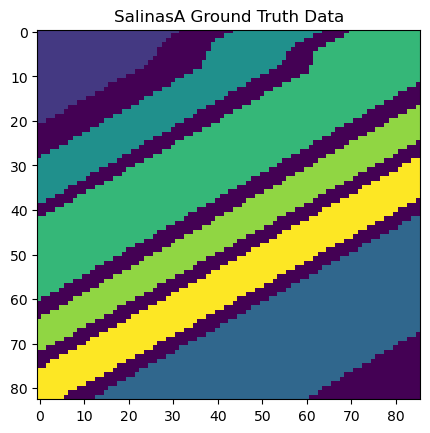

In [18]:
plt.imshow(map_gt)
plt.title("SalinasA Ground Truth Data")

Text(0.5, 1.0, 'LAND on SalinasA, Budget = 12')

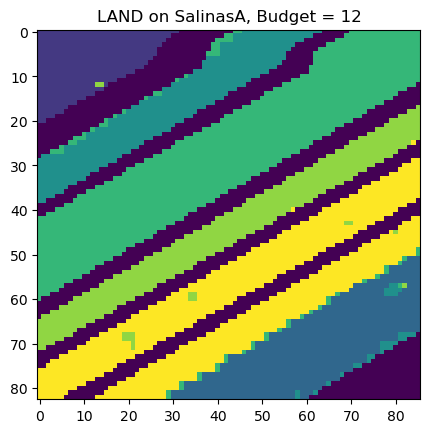

In [20]:
plt.imshow(mapped_matrix * mask.reshape(83, 86))
plt.title("LAND on SalinasA, Budget = 12")

Text(0.5, 1.0, 'LEND on SalinasA, Budget = 12')

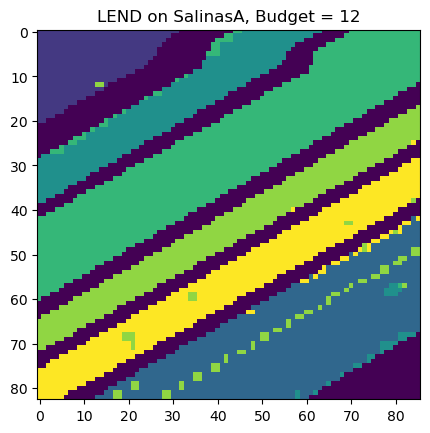

In [21]:
plt.imshow(map_lend*mask.reshape(83, 86))
plt.title("LEND on SalinasA, Budget = 12")